Authors: Luka Grubišić, Marko Hajba, Domagoj Lacmanović

---

We are solving the problem of approximating the landscape function in 2D:
$$ -\triangle u+V_\omega u = \boldsymbol 1 $$
on the domain $[-10, 10]^2$ with periodic boundary conditions. It is a positive function in $C^1(\Omega)$. Its reciprocal $W=1/u$ is called the effective potential and it incurs localization on bounded states. We use heuristic formula from (Arnold et al.)
$$
    \epsilon\approx(1+\dfrac{n}{4})W_{min}
$$
that relates the effective potential and the energy of a localized excited states.

The potential $V_\omega$ is constructed as superposition of sixteen Gaussians $G(x)=\alpha \exp(-|x_1-c_1|^2/k_1^2-|x_2-c_2|^2/k_2^2)$. The centers $c=(c_1,c_2)$ were chosen randomly inside each block of the $4\times 4$ uniform quadrilateral tessellation of $\Omega$. The constants $\alpha, k_i,i=1,2$ were chosen randomly from intervals $[8,128]$ and $[1,1.5]$, respectively. To introduce local defects we further randomly choose three Gaussian bells and removed them from the potential lattice. The choice of Gaussian bells to be removed was restricted, so that the boundary conditions were respected and that none of the erased bells were pairwise adjacent. 

FEniCS solution of the problem is used for benchmarking.

In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i 's|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|' /usr/include/dolfin/la/PETScLUSolver.h
    !pip3 -q install --upgrade sympy
    import dolfin

In [ ]:
## Load important packages
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib inline

from tensorflow.keras import layers
from datetime import datetime

from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
import scipy
from scipy import integrate
import scipy.io as sio
import random
import time

from dolfin import *

In [ ]:
## Load data
mat1 = sio.loadmat('Ex7_Variational_data.mat')
pot_d = mat1['pot2D']
print(pot_d.shape)

(1, 10000)


In [ ]:
# Define mesh
mesh = RectangleMesh(Point(-10.0, -10.0), Point(10.0, 10.0), 50, 50 ) #, "right/left")
print("Plotting a RectangleMesh")
plt.figure()
plot(mesh, title="Mesh of the domain")

In [ ]:
## define Periodic boundary conditions
class PeriodicBoundary(SubDomain):
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], -10) or near(x[1], -10)) and 
                (not ((near(x[0], -10) and near(x[1], 10)) or 
                        (near(x[0], 10) and near(x[1], -10)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], 10) and near(x[1], 10):
            y[0] = x[0] - 20.
            y[1] = x[1] - 20.
        elif near(x[0], 10):
            y[0] = x[0] - 20.
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 20.

In [ ]:
## Define Function Space V
pbc = PeriodicBoundary()
V = FunctionSpace(mesh, 'Lagrange', 2, constrained_domain = PeriodicBoundary())

func = Function(V)
print(func.vector()[:].shape)

(10000,)


In [ ]:
pot = Function(V)
pot_d = pot_d.flatten()
for i in range(len(pot_d)):
  pot.vector()[i] = pot_d[i]

In [ ]:
#define problem in FEniCS
u = TrialFunction(V)
v = TestFunction(V)

a = (inner(grad(u), grad(v)) \
      + pot*u*v)*dx
m = u*v*dx

A = PETScMatrix()
M = PETScMatrix()
_ = PETScVector()
L = Constant(0.)*v*dx
assemble(a, tensor=A)
assemble(m, tensor=M)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
## Solve Hu = 1 in FEniCS for post-processing
L1 = Constant(1.0)*v*dx
sol = Function(V)
solve(a == L1, sol)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
##############################################
########### obtain coordinates ###############
##############################################

element = V.element()
dofmap = V.dofmap()
indices_d = np.zeros((101, 101)).astype('int')
pot_d = np.zeros((10201,)).astype('float32')
u_d = np.zeros((10201,)).astype('float32')
x = np.zeros((10000, 2))
max = 0
min = 0
for cell in cells(mesh):
    #print(element.tabulate_dof_coordinates(cell))   # indices in func.vector(), 6 per cell for deg2
    #print(dofmap.cell_dofs(cell.index()))           # points corresponding to baove (6 pts for deg 2)
    for i in range(len(element.tabulate_dof_coordinates(cell))):
      indices = dofmap.cell_dofs(cell.index())
      points = np.round(element.tabulate_dof_coordinates(cell), decimals=1)
      
      indices_d[ int(np.round(np.abs(-10 - points[i, 0])*5,  decimals=1)), int(np.round(np.abs(-10 - points[i, 1])*5,  decimals=1)) ] = indices[i]
      x[indices[i]] = points[i]

indices_d = indices_d[0:101, 0:101].flatten()
start = time.time()
#for j in range(len(pot2D_test)):
  #pot2D = Function(V)
for i in range(len(indices_d)):
    pot_d[i] = pot.vector()[indices_d[i]]
    u_d[i] = sol.vector()[indices_d[i]]

print('Time:', time.time()-start)

Time: 0.19371724128723145


In [ ]:
## define activation function
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
def activ(x):
    return K.sigmoid(x)

In [ ]:
## Define Neural network architecture

def NN(x):

    tf.random.set_seed(1)
    init1 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init2 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init3 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init4 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init5 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init6 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init7 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init8 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init9 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init10 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init11 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init12 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init13 = tf.keras.initializers.GlorotUniform(seed = 5)

    inputs = layers.Input(shape = (2, ), name = "inputs")
    h1 = layers.Dense(10, name = "h1", kernel_initializer=init1, bias_initializer=tf.keras.initializers.Zeros())(inputs)
    h1 = layers.Activation(activ)(h1)
    h2 = layers.Dense(10, name = "h2", kernel_initializer=init2, bias_initializer=tf.keras.initializers.Zeros())(h1)
    h2 = layers.Activation(activ)(h2)
    c1 = layers.Concatenate()([inputs, h2])
    
    h3 = layers.Dense(10, name = "h3", kernel_initializer=init3, bias_initializer=tf.keras.initializers.Zeros())(c1)
    h3 = layers.Activation(activ)(h3)
    h4 = layers.Dense(10, name = "h4", kernel_initializer=init4, bias_initializer=tf.keras.initializers.Zeros())(h3)
    h4 = layers.Activation(activ)(h4)
    c2 = layers.Concatenate()([c1, h4])
    
    h5 = layers.Dense(10, name = "h5", kernel_initializer=init5, bias_initializer=tf.keras.initializers.Zeros())(c2)
    h5 = layers.Activation(activ)(h5)
    h6 = layers.Dense(10, name = "h6", kernel_initializer=init6, bias_initializer=tf.keras.initializers.Zeros())(h5)
    h6 = layers.Activation(activ)(h6)
    c3 = layers.Concatenate()([c2, h6])
    
    h7 = layers.Dense(10, name = "h7", kernel_initializer=init7, bias_initializer=tf.keras.initializers.Zeros())(c3)
    h7 = layers.Activation(activ)(h7)
    h8 = layers.Dense(10, name = "h8", kernel_initializer=init8, bias_initializer=tf.keras.initializers.Zeros())(h7)
    h8 = layers.Activation(activ)(h8)
    c4 = layers.Concatenate()([c3, h8])
    
    h9 = layers.Dense(10, name = "h9", kernel_initializer=init9, bias_initializer=tf.keras.initializers.Zeros())(c4)
    h9 = layers.Activation(activ)(h9)
    h10 = layers.Dense(10, name = "h10", kernel_initializer=init10, bias_initializer=tf.keras.initializers.Zeros())(h9)
    h10 = layers.Activation(activ)(h10)
    c5 = layers.Concatenate()([c4, h10])

    h11 = layers.Dense(10, name = "h11", kernel_initializer=init11, bias_initializer=tf.keras.initializers.Zeros())(c5)
    h11 = layers.Activation(activ)(h11)
    h12 = layers.Dense(10, name = "h12", kernel_initializer=init12, bias_initializer=tf.keras.initializers.Zeros())(h11)
    h12 = layers.Activation(activ)(h12)
    c6 = layers.Concatenate()([c5, h12])
    
    out = layers.Dense(1, name = "out", kernel_initializer=init13, bias_initializer=tf.keras.initializers.Zeros())(c6)

    # define model
    model = tf.keras.Model(inputs, out)
    # define optimizer
    return model
    
# Show model arhitecture
model = NN(x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 2)]          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 10)           30          inputs[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 10)           0           h1[0][0]                         
__________________________________________________________________________________________________
h2 (Dense)                      (None, 10)           110         activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
## Define loss function
def get_loss(x, K, M, model):
  def loss(y_true, y_pred):
    
    y_pred = model(x)
    
    loss_value = 0.5*tf.multiply(tf.multiply(tf.transpose(y_pred), K), y_pred)
    loss_value = loss_value - tf.multiply(tf.multiply(tf.ones((1, len(y_pred))), M), y_pred)

    return loss_value
  return loss

In [ ]:
model = NN(x)
## transform A and M into tensors K and M
stiff = tf.cast(A.array(), dtype='float32')
mass = tf.cast(M.array(), dtype='float32')

var_loss = get_loss(x, stiff, mass, model)

In [ ]:
## Model compile
optim = tf.keras.optimizers.Adam(lr=0.001)
model.compile( loss = var_loss, optimizer=optim)

In [ ]:
## Example of model training -  in the article we used learning scheduler and additional callback function
no_epoch = 100000

start = time.time()
history = model.fit(x, model(x),
      verbose = 0,
      batch_size = len(x),
      epochs = no_epoch,
      )

print('Evaluation time:', time.time() - start)

In [ ]:
## Analyse L2 and H1 error of the VPINN solution w.r.t. FEniCS solution

pred = model(x)
pred = tf.reshape(pred, (len(x), ))
pred_fun = Function(V)

for i in range(len(pred_fun.vector()[:])):
  pred_fun.vector()[i] = pred[i]

print('L2 relative error w.r.t. FEniCS solution:', errornorm(sol, pred_fun)/norm(sol)*100, '%')
print('H1 relative error w.r.t. FEniCS solution:', errornorm(sol, pred_fun, 'H1')/norm(sol, 'H1')*100, '%')

L2 relative error w.r.t. FEniCS solution: 0.7997987656348968 %
H1 relative error w.r.t. FEniCS solution: 2.69941076609991 %


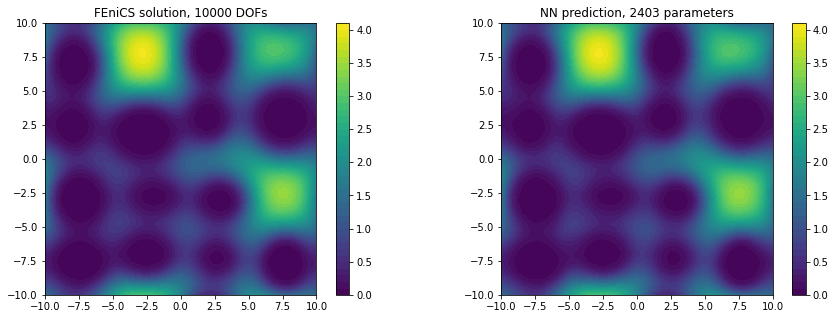

In [ ]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1,2, 1)
cs = plot(sol)
plt.title('FEniCS solution, 10000 DOFs')
plt.colorbar(cs)

ax = plt.subplot(1, 2, 2)
cn = plot(pred_fun)
plt.title('NN prediction, 2403 parameters')
plt.colorbar(cn)

In [ ]:
## Save the VPINN solution in .pvd format
file = File('landscape_3loc_NN_2403params_200k.pvd')
file << pred_fun

In [ ]:
## Save the model
model.save('/content/drive/My Drive/Marko/VPINN_ex7/2403params_6blocks/VPINN_2403_ex7_NN_200k_6blocks.h5')

In [ ]:
#####################
###### Analyse ######
#####################

In [ ]:
## Define problem for the eigenvalue solver in FEniCS
u = TrialFunction(V)
v = TestFunction(V)

a = (inner(grad(u), grad(v)) \
     + pot*u*v)*dx
m = u*v*dx

A = PETScMatrix()
M = PETScMatrix()
_ = PETScVector()
L = Constant(0.)*v*dx
assemble(a, tensor=A)
assemble(m, tensor=M)

# create eigensolver
import time

start = time.time()
eigensolver = SLEPcEigenSolver(A,M)
eigensolver.parameters['spectrum'] = 'smallest magnitude'
eigensolver.parameters['tolerance'] = 1.e-15

#solve for eigenpairs and store them in variables
eigensolver.solve(5)
print(eigensolver.get_number_converged())

print('Time:', time.time()-start)

U0 = Function(V)
U1 = Function(V)
U2 = Function(V)

r0, c, rx, cx = eigensolver.get_eigenpair(0)
print( 'eigenvalue 0:', r0)
U0.vector()[:] = rx
r1, c, rx, cx = eigensolver.get_eigenpair(1)
print( 'eigenvalue 1:', r1)
U1.vector()[:] = rx
r2, c, rx, cx = eigensolver.get_eigenpair(2)
print( 'eigenvalue 2:', r2)
U2.vector()[:] = rx

5
Time: 4.749382257461548
eigenvalue 0: 0.37306842222503467
eigenvalue 1: 0.4432354190963049
eigenvalue 2: 0.5084659494032435


In [ ]:
## Define effective potential
W_NN = Function(V)

for i in range(len(W_NN.vector()[:])):
  W_NN.vector()[i] = 1/pred_fun.vector()[i]

In [ ]:
## Project into space V2
mesh2 = RectangleMesh(Point(-10.0, -10.0), Point(10.0, 10.0), 500, 500 )
V2 = FunctionSpace(mesh2, "CG", 1)
W_proj = project(W_NN, V2)

X = np.linspace(-10, 10, 101)
Y = np.linspace(-10, 10, 101)
W_d = np.zeros([len(X), len(Y)])

for i in range(101):
  for j in range(101):
    W_d[i, j]= W_proj(X[i], Y[j])


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
## Locate local minima of the effective potential
min_cand = list()
for i in range(1, 100):
  for j in range(1, 100):
    if W_d[i, j] > 0.1 and W_d[i, j] < W_d[i+1, j] and W_d[i, j] < W_d[i, j+1] and W_d[i, j] < W_d[i-1, j] and W_d[i, j] < W_d[i, j-1]:
          print('Indices', i, j, 'Points:', X[i], Y[j], 'Value:', W_d[i, j])
          tmp = list()
          tmp.extend((i, j, X[i], Y[j], W_d[i,j]))
          min_cand.append(tmp)
min_cand.sort(key = lambda x: x[4])
print(min_cand)

Indices 22 49 Points: -5.6 -0.1999999999999993 Value: 1.3910033019489203
Indices 23 48 Points: -5.3999999999999995 -0.3999999999999986 Value: 1.3673498569446374
Indices 24 47 Points: -5.199999999999999 -0.5999999999999996 Value: 1.346255160586184
Indices 25 46 Points: -5.0 -0.7999999999999989 Value: 1.3327519666026242
Indices 26 45 Points: -4.8 -1.0 Value: 1.3357814415728144
Indices 27 26 Points: -4.6 -4.8 Value: 1.3579293272988477
Indices 36 60 Points: -2.8 2.0 Value: 68.87438754519319
Indices 36 89 Points: -2.8 7.800000000000001 Value: 0.24758354261045462
Indices 53 24 Points: 0.6000000000000014 -5.199999999999999 Value: 1.0479483643359524
Indices 84 90 Points: 6.800000000000001 8.0 Value: 0.33385439662194055
Indices 88 37 Points: 7.600000000000001 -2.5999999999999996 Value: 0.29020603595213257
[[36, 89, -2.8, 7.800000000000001, 0.24758354261045462], [88, 37, 7.600000000000001, -2.5999999999999996, 0.29020603595213257], [84, 90, 6.800000000000001, 8.0, 0.33385439662194055], [53, 24, 

In [ ]:
## Calculate and show relative error of the approximations
print(1.5*min_cand[0][4])
print(1.5*min_cand[1][4])
print(1.5*min_cand[2][4])

print('Relative error in first eigenvalue:', np.abs((1.5*min_cand[0][4] - r0)/r0)*100, '%')
print('Relative error in second eigenvalue:', np.abs((1.5*min_cand[1][4] - r1)/r1)*100, '%')
print('Relative error in third eigenvalue:', np.abs((1.5*min_cand[2][4] - r2)/r2)*100, '%')

0.3713753139156819
0.43530905392819885
0.5007815949329109
Relative error in first eigenvalue: 0.4538331867529336 %
Relative error in second eigenvalue: 1.7882968794025467 %
Relative error in third eigenvalue: 1.5112820198385633 %


eigenvalue 1 : 0.37306842222503467
eigenvalue 2 : 0.4432354190963049
eigenvalue 3 : 0.5084659494032435


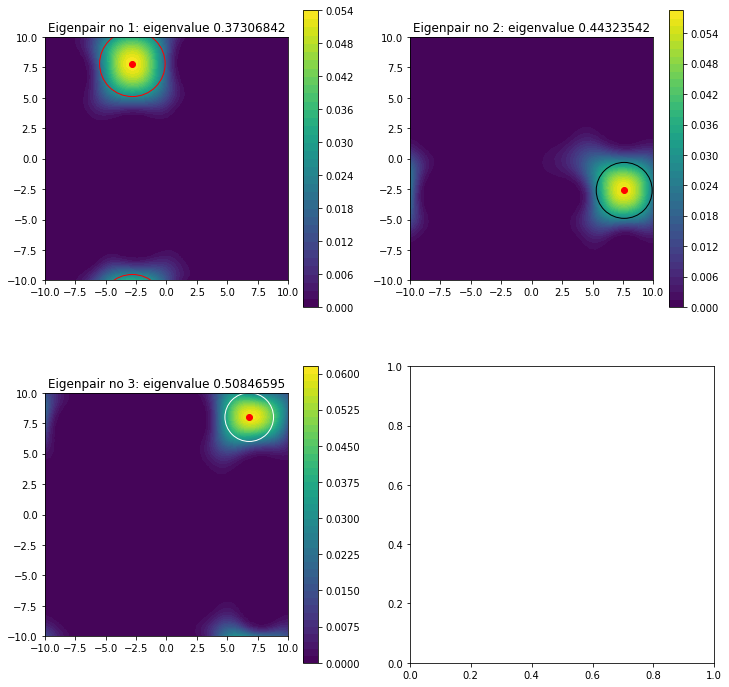

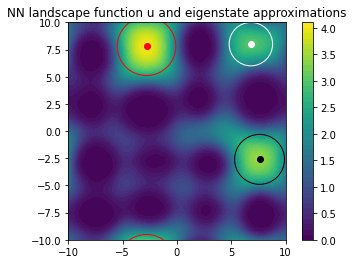

In [ ]:
## Plot First 3 localized eiegnstates and their approximation locations from the effective potential W
## Locations are then plotted on top of the landscape function u for better visibility
u = Function(V)
eigs = np.zeros((3, ))
plt.figure(figsize=(12, 12))
for i in range(0,4):
    ax = plt.subplot(2, 2, i + 1)
    if i+1 == 4:
        figure, axes = plt.subplots()
        cs = plot(pred_fun)
        plt.colorbar(cs)
        plt.title('NN landscape function u and eigenstate approximations')
        plt.plot(min_cand[0][2],  min_cand[0][3], 'ro')
        plt.plot(min_cand[1][2],  min_cand[1][3], 'ko')
        plt.plot(min_cand[2][2],  min_cand[2][3], 'wo')
        rc0 = 1/(min_cand[0][4]*1.5)
        rc1 = 1/(min_cand[1][4]*1.5)
        rc2 = 1/(min_cand[2][4]*1.5)
        draw_circle = plt.Circle((min_cand[0][2],  min_cand[0][3]), rc0, fill=False, color = 'r', clip_on=True)
        draw_circle4 = plt.Circle((min_cand[0][2], min_cand[0][3]-20), rc0, fill=False, color = 'r', clip_on=True) # periodicity
        draw_circle2 = plt.Circle((min_cand[1][2],  min_cand[1][3]), rc1, fill=False, color = 'k', clip_on=True)
        draw_circle3 = plt.Circle((min_cand[2][2],  min_cand[2][3]), rc2, fill=False, color = 'w', clip_on=True)
        axes.set_aspect(1)
        axes.add_artist(draw_circle)
        axes.add_artist(draw_circle2)
        axes.add_artist(draw_circle3)
        axes.add_artist(draw_circle4)
    else:    
      #extract next eigenpair
      r, c, rx, cx = eigensolver.get_eigenpair(i)
      print( 'eigenvalue',i+1, ':', r)
      #assign eigenvector to function
      u.vector()[:] = np.abs(rx)
      eigs[i] = r
      #cs = plot(u,interactive=False)
      cs = plot(u)
      plt.title('Eigenpair no %i' %(i+1) + ': eigenvalue %2.8f' %(r))
      plt.colorbar(cs)
      plt.plot(min_cand[i][2],  min_cand[i][3], 'ro')
      ri = 1/(min_cand[i][4]*1.5)
      if i == 0:
        draw_circle = plt.Circle((min_cand[i][2],  min_cand[i][3]), ri, fill=False, color = 'r', clip_on=True)
        # periodicity
        draw_circle2 = plt.Circle((min_cand[i][2],  min_cand[i][3]-20), ri, fill=False, color = 'r', clip_on=True)
        ax.add_artist(draw_circle2)
      if i == 1:
        draw_circle = plt.Circle((min_cand[i][2],  min_cand[i][3]), ri, fill=False, color = 'k', clip_on=True)
      if i == 2:
        draw_circle = plt.Circle((min_cand[i][2],  min_cand[i][3]), ri, fill=False, color = 'w', clip_on=True)

      ax.add_artist(draw_circle)

plt.show()

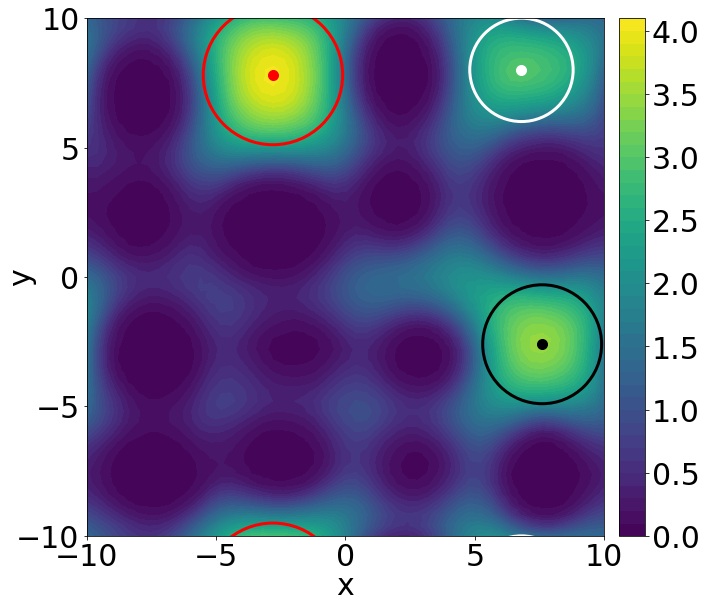

In [ ]:
## Approximation location are plotted on top of the landscape function u, with all information on labels, axes etc.

from mpl_toolkits.axes_grid1 import make_axes_locatable
figure, axes = plt.subplots(figsize=(10, 10))

cs = plot(pred_fun)
plt.plot(min_cand[0][2],  min_cand[0][3], 'ro', markersize=10)
plt.plot(min_cand[1][2],  min_cand[1][3], 'ko', markersize=10)
plt.plot(min_cand[2][2],  min_cand[2][3], 'wo', markersize=10)
rc0 = 1/(min_cand[0][4]*1.5)
rc1 = 1/(min_cand[1][4]*1.5)
rc2 = 1/(min_cand[2][4]*1.5)
draw_circle = plt.Circle((min_cand[0][2],  min_cand[0][3]), rc0, fill=False, color = 'r', linewidth = 3, clip_on=True)
draw_circle4 = plt.Circle((min_cand[0][2], min_cand[0][3]-20), rc0, fill=False, color = 'r', linewidth = 3, clip_on=True) # periodicity
draw_circle2 = plt.Circle((min_cand[1][2],  min_cand[1][3]), rc1, fill=False, color = 'k', linewidth = 3, clip_on=True)
draw_circle3 = plt.Circle((min_cand[2][2],  min_cand[2][3]), rc2, fill=False, color = 'w', linewidth = 3, clip_on=True)
draw_circle5 = plt.Circle((min_cand[2][2],  min_cand[2][3]-20), rc2, fill=False, color = 'w', linewidth = 3, clip_on=True)
axes.set_aspect(1)
axes.add_artist(draw_circle)
axes.add_artist(draw_circle2)
axes.add_artist(draw_circle3)
axes.add_artist(draw_circle4)
axes.add_artist(draw_circle5)

plt.xticks([-10, -5, 0, 5, 10], fontsize=30)
plt.yticks([-10, -5, 0, 5, 10], fontsize=30)
plt.xlabel('x', labelpad = 0, fontsize=30)
plt.ylabel('y', labelpad = -20, fontsize=30)
divider = make_axes_locatable(axes)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(cs, cax=cax)
cbar.ax.tick_params(labelsize=30)

In [ ]:
## Save data
eigs = np.array([r0, r1, r2])
print(eigs)
sio.savemat('VPINN_2403params_200k_6blocks.mat', 
            {'pot2D':pot.vector()[:], 'u':sol.vector()[:], 'x':x, 'pot2D_d':pot_d, 
             'u_d':u_d, 'indices':indices_d, 'u_NN':pred_fun.vector()[:],
             'W_min':np.array(min_cand), 'eigs_FEniCS':eigs})

[0.37306842 0.44323542 0.50846595]
